In [74]:
import artm

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

sns.set(style="darkgrid", palette="Set2")

from topicnet.dataset_manager import api

# topicnet imports
from topicnet.cooking_machine.cubes import (
    CubeCreator,
    GreedyStrategy,
    PerplexityStrategy,
    RegularizationControllerCube,
    RegularizersModifierCube,
)
from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.models import BaseScore
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.model_constructor import add_standard_scores
from topicnet.cooking_machine.model_constructor import init_simple_default_model
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from topicnet.viewers.top_tokens_viewer import TopTokensViewer

In [75]:
EXPERIMENT_PATH = './data/exp/'

DATASET_PATH = './data/20_News_dataset/train_preprocessed.csv'

### Обучаем тематическую модель

In [76]:
if not os.path.exists(EXPERIMENT_PATH):
    os.mkdir(EXPERIMENT_PATH)
else:
    ! rm -rf $EXPERIMENT_PATH
    os.mkdir(EXPERIMENT_PATH)

In [77]:
%%time

from topicnet.cooking_machine.recipes import BaselineRecipe

training_pipeline = BaselineRecipe()

training_pipeline.format_recipe(
    dataset_path=DATASET_PATH,
    topic_number=10,
    background_topic_number=1,
    modality_list=['@lemmatized']
);


CPU times: user 540 µs, sys: 344 µs, total: 884 µs
Wall time: 259 µs


In [78]:
experiment, dataset = training_pipeline.build_experiment_environment(save_path=EXPERIMENT_PATH,)


In [79]:
%%time

models = experiment.run(dataset)

CPU times: user 51min 15s, sys: 14min 43s, total: 1h 5min 58s
Wall time: 22min 52s


In [80]:
final_model = list(models)[0]

In [81]:
import importlib
importlib.reload(coherence_metrics)
importlib.reload(chains_interpretability)
importlib.reload(utils)

<module 'utils' from '/home/linuxuser0x32/Documents/M1P/experiment/utils.py'>

In [82]:
import coherence_metrics 
import chains_interpretability
import utils

In [83]:
ppmi = utils.PPMIHandler('ppmi_tf_')

### Вычисляем интерпретируемость

In [89]:
import json
f = open('chains.json')
chains = json.load(f)

In [90]:
class ChainsInterpretability:
    def __init__(self, chains):
        super().__init__()
        self.chains = chains

    def _get_topics(self, model):
        return list(model.get_phi().columns)
    
    def _calculate_interpretability(self, topics, phi):
        data = [[] for _ in range(len(topics))]
        for chain in self.chains:
            probs = phi.loc[list(chain)].to_numpy()
            likelyhood = np.log(probs).sum(axis=0)
            data[np.argmax(likelyhood)].append(np.max(likelyhood))
        print([len(row) for row in data])
        return [np.mean(row) if len(row) else -np.inf for row in data]

    def call(self, model, modality='@lemmatized'):
        topics = self._get_topics(model)
        phi = model.get_phi().loc[modality]
        result = self._calculate_interpretability(topics, phi)
        return np.array(result)

In [91]:
%%time
score = ChainsInterpretability(chains)

CPU times: user 14 µs, sys: 10 µs, total: 24 µs
Wall time: 38.9 µs


In [92]:
%%time
inter = score.call(final_model)

[4, 7, 17, 2, 13, 14, 1, 0, 2, 11, 17]
CPU times: user 5.46 s, sys: 2.3 s, total: 7.76 s
Wall time: 3.47 s


### Вычисляем когерентности

In [84]:
score = coherence_metrics.NewmanCoherence()

In [85]:
%%time
newmanCoh10 = score.call(final_model, ppmi, k=10)

CPU times: user 5.65 s, sys: 2.53 s, total: 8.17 s
Wall time: 3.56 s


In [86]:
newmanCoh20 = score.call(final_model, ppmi, k=20)

In [87]:
newmanCoh50 = score.call(final_model, ppmi, k=50)

In [88]:
newmanCoh100 = score.call(final_model, ppmi, k=100)

In [93]:
mulCohScore = coherence_metrics.CustomRelCoherence(lambda x, y : x * y)
mulCoh = mulCohScore.call(final_model, ppmi)

In [94]:
%%time
sqrtCohScore = coherence_metrics.CustomRelCoherence(lambda x, y : math.sqrt(x * y))
sqrtCoh = sqrtCohScore.call(final_model, ppmi)

CPU times: user 50min 16s, sys: 25min 39s, total: 1h 15min 56s
Wall time: 26min 54s


In [95]:
%%time
multEpsCohScore = coherence_metrics.CustomRelCoherence(lambda x, y : x * y >= 1e-10)
multEpsCohCoh = multEpsCohScore.call(final_model, ppmi)


CPU times: user 14min 15s, sys: 7min 6s, total: 21min 21s
Wall time: 7min 48s


In [96]:
%%time
sumCohScore = coherence_metrics.CustomRelCoherence(lambda x, y : x + y if x > 0 and y > 0 else 0)
sumCoh = sumCohScore.call(final_model, ppmi)

CPU times: user 33min 52s, sys: 15min 46s, total: 49min 38s
Wall time: 19min 55s


In [97]:
inter

array([-18.4004612 , -19.53823471, -16.94548035, -26.7927742 ,
       -17.8148365 , -17.33802986, -11.61606979,         -inf,
       -18.24101257, -20.45960808, -27.90028381])

In [98]:
import importlib
importlib.reload(coherence_metrics)
importlib.reload(chains_interpretability)
importlib.reload(utils)

<module 'utils' from '/home/linuxuser0x32/Documents/M1P/experiment/utils.py'>

In [99]:
import coherence_metrics 
import chains_interpretability
import utils

In [100]:
del ms

In [101]:
ms = utils.MetricsStorage()

In [102]:
ms.add('Newman_10', newmanCoh10)
ms.add('Newman_20', newmanCoh20)
ms.add('Newman_50', newmanCoh50)
ms.add('Newman_100', newmanCoh100)
ms.add(r'$\phi_u \phi_v$', mulCoh)
ms.add(r'$[\phi_u \phi_v] > \varepsilon$', multEpsCohCoh)
ms.add(r'$[\phi_u > 0][\phi_v > 0] (\phi_u + \phi_v)$', sumCoh)
ms.add(r'$\sqrt{\phi_u \phi_v}$', sqrtCoh)


In [104]:
ms.getCorrelationList(inter[:10])

(['Newman_10',
  'Newman_20',
  'Newman_50',
  'Newman_100',
  '$\\phi_u \\phi_v$',
  '$[\\phi_u \\phi_v] > \\varepsilon$',
  '$[\\phi_u > 0][\\phi_v > 0] (\\phi_u + \\phi_v)$',
  '$\\sqrt{\\phi_u \\phi_v}$'],
 [0.16363636363636364,
  -0.04242424242424241,
  -0.18787878787878787,
  -0.16363636363636364,
  -0.18787878787878787,
  0.11515151515151514,
  0.0303030303030303,
  -0.07878787878787878])

Text(0, 0.5, 'Spearman correlation')

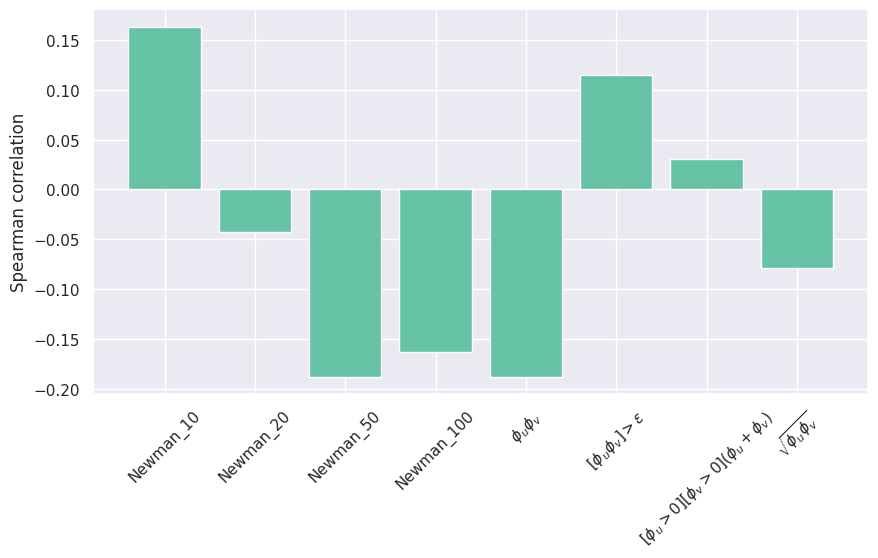

In [109]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
plt.bar(*ms.getCorrelationList(inter[:10]))
plt.ylabel('Spearman correlation')